# Consumer Complaint

In [1]:
import pyspark
from pyspark import SparkContext

sc = SparkContext(master='local', appName = 'Spark context')

In [2]:
import findspark
findspark.init()
import pyspark
findspark.find()

'/Users/vunguyen/server/spark-2.4.6-bin-hadoop2.7'

In [3]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
'''
conf= pyspark.SparkConf().setAppName('tets_app').setMaster('local')
sc=pyspark.SparkContext(conf=conf)
sc
'''

#sc= SparkContext()
spark = (SparkSession
         .builder
         .appName('Session Spark App')
         .getOrCreate())
spark

1. Đọc data

In [4]:
df = spark.read.csv('File/complaints.csv', header = True, inferSchema=True)

2. Cho biết số dòng, in schema

In [5]:
df.count()

2083368

In [6]:
df.printSchema()

root
 |-- Date received: string (nullable = true)
 |-- Product: string (nullable = true)
 |-- Sub-product: string (nullable = true)
 |-- Issue: string (nullable = true)
 |-- Sub-issue: string (nullable = true)
 |-- Consumer complaint narrative: string (nullable = true)
 |-- Company public response: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- State: string (nullable = true)
 |-- ZIP code: string (nullable = true)
 |-- Tags: string (nullable = true)
 |-- Consumer consent provided?: string (nullable = true)
 |-- Submitted via: string (nullable = true)
 |-- Date sent to company: string (nullable = true)
 |-- Company response to consumer: string (nullable = true)
 |-- Timely response?: string (nullable = true)
 |-- Consumer disputed?: string (nullable = true)
 |-- Complaint ID: string (nullable = true)



In [8]:
for row in df.head(3):
    print(row)
    print('\n')

Row(Date received='2019-09-24', Product='Debt collection', Sub-product='I do not know', Issue='Attempts to collect debt not owed', Sub-issue='Debt is not yours', Consumer complaint narrative='transworld systems inc. ', Company public response=None, Company=None, State=None, ZIP code=None, Tags=None, Consumer consent provided?=None, Submitted via=None, Date sent to company=None, Company response to consumer=None, Timely response?=None, Consumer disputed?=None, Complaint ID=None)


Row(Date received='is trying to collect a debt that is not mine', Product=' not owed and is inaccurate."', Sub-product=None, Issue='TRANSWORLD SYSTEMS INC', Sub-issue='FL', Consumer complaint narrative='335XX', Company public response=None, Company='Consent provided', State='Web', ZIP code='2019-09-24', Tags='Closed with explanation', Consumer consent provided?='Yes', Submitted via='N/A', Date sent to company='3384392', Company response to consumer=None, Timely response?=None, Consumer disputed?=None, Complain

In [9]:
from pyspark.sql.functions import col,udf
from pyspark.sql.functions import isnan,when,count,col

3. Kiểm tra dữ liệu nan, null

In [10]:
df.select([count(when(isnan(c),c)).alias(c) for c in df.columns]).toPandas().T

,0
Date received,0
Product,0
Sub-product,0
Issue,0
Sub-issue,0
Consumer complaint narrative,0
Company public response,0
Company,0
State,0
ZIP code,0


In [11]:
df.select([count(when(col(c).isNull(),c)).alias(c) for c in df.columns]).toPandas().T

,0
Date received,40
Product,209258
Sub-product,511176
Issue,325183
Sub-issue,931248
Consumer complaint narrative,1454171
Company public response,1412034
Company,573431
State,597994
ZIP code,673059


4. Kiểm tra dữ liệu trùng, xoá

In [12]:
num_rows = df.count()
num_dist_rows = df.distinct().count()
dup_rows = num_rows - num_dist_rows

In [13]:
display(num_rows, num_dist_rows, dup_rows)

2083368

2020609

62759

In [14]:
df = df.drop_duplicates()

In [15]:
df.distinct().count()

2020609

5. Kiểm tra dữ liệu NUll, tính tỉ lệ %, xoá

In [16]:
null_data = df.select([count(when(col(c).isNull(),c)).alias(c) for c in df.columns]).toPandas().T

In [17]:
null_data

,0
Date received,39
Product,178373
Sub-product,472168
Issue,281416
Sub-issue,884470
Consumer complaint narrative,1405173
Company public response,1353196
Company,513337
State,537111
ZIP code,611785


In [19]:
null_data['percentage'] = (null_data[0]/num_dist_rows)*100

In [20]:
null_data

,0,percentage
Date received,39,0.001930
Product,178373,8.827685
Sub-product,472168,23.367608
Issue,281416,13.927286
Sub-issue,884470,43.772447
Consumer complaint narrative,1405173,69.542054
Company public response,1353196,66.969711
Company,513337,25.405064
State,537111,26.581639
ZIP code,611785,30.277258


6. Tạo dữ liệu mới, trong đó k có các dữ liệu thiếu trên 30%

In [22]:
data_sub = df.select(['Date received', 'Product', 'Sub-product',
                       'Issue','Company','State',
                        'Consumer consent provided?','Submitted via'])

In [23]:
data_sub.show(2)

+--------------------+--------------------+----------------+--------------------+--------------------+-----+--------------------------+-------------+
|       Date received|             Product|     Sub-product|               Issue|             Company|State|Consumer consent provided?|Submitted via|
+--------------------+--------------------+----------------+--------------------+--------------------+-----+--------------------------+-------------+
|o While we do not...| we have been inf...|            null|                null|                null| null|                      null|         null|
|          2019-09-19|Credit reporting,...|Credit reporting|Improper use of y...|TRANSUNION INTERM...|   WI|          Consent provided|          Web|
+--------------------+--------------------+----------------+--------------------+--------------------+-----+--------------------------+-------------+
only showing top 2 rows



7. Xoá các dòng có 'Date received' là null hoặc product là null

In [24]:
data_sub = data_sub.dropna(how='any', subset=['Date received', 'Product'])

In [25]:
data_sub.select([count(when(col(c).isNull(),c)).alias(c) for c in data_sub.columns]).toPandas().T

,0
Date received,0
Product,0
Sub-product,332225
Issue,141159
Company,373348
State,397120
Consumer consent provided?,399331
Submitted via,381799


8.tạo cột 'date_from_text' chứa dữ liệu từ 'Date received' nếu có, nếu k là '', lọc dữ liệu data_sub với yêu cầu date_from_text khác ''

In [26]:
from pyspark.sql import functions as F

data_sub = data_sub.withColumn('date_from_text', F.regexp_extract(data_sub['Date received'], 
                                                                 r'(\d{4}-\d{1,2}-\d{1,2})', 0))

In [27]:
data_sub.select('date_from_text', 'Date received').head(5)

[Row(date_from_text='', Date received='o While we do not know the details of the XXXX/CMHL compensation structure'),
 Row(date_from_text='2019-09-19', Date received='2019-09-19'),
 Row(date_from_text='', Date received='-XX/XX/XXXX letter where Certegy Payment Solutions '),
 Row(date_from_text='2019-04-04', Date received='2019-04-04'),
 Row(date_from_text='2019-02-18', Date received='2019-02-18')]

In [28]:
data_sub = data_sub.filter(data_sub['date_from_text']!='')

In [29]:
data_sub.select('date_from_text', 'Date received').head(10)

[Row(date_from_text='2019-09-19', Date received='2019-09-19'),
 Row(date_from_text='2019-04-04', Date received='2019-04-04'),
 Row(date_from_text='2019-02-18', Date received='2019-02-18'),
 Row(date_from_text='2019-05-25', Date received='2019-05-25'),
 Row(date_from_text='2019-03-28', Date received='2019-03-28'),
 Row(date_from_text='2018-12-28', Date received='2018-12-28'),
 Row(date_from_text='2019-08-08', Date received='2019-08-08'),
 Row(date_from_text='2019-04-04', Date received='2019-04-04'),
 Row(date_from_text='2019-04-22', Date received='2019-04-22'),
 Row(date_from_text='2019-03-27', Date received='2019-03-27')]

9. Tạo cột 'CCP' với dữ liệu từ col 'Consumer consent provided?', điền 'Consent not provided' thay cho null

In [41]:
data_sub.select(['Consumer consent provided?']).distinct().count()

12830

In [42]:
data_sub = data_sub.withColumn('CCP', data_sub['Consumer consent provided?'])

In [43]:
data_sub = data_sub.fillna('Consent not provided', subset='CCP')

10. Tạo col 'SV' mới lấy dữ liệu từ 'Submitted via'

In [44]:
data_sub = data_sub.withColumn('SV', data_sub['Submitted via'])

In [45]:
data_sub = data_sub.fillna('Other', subset='SV')

11. Tạo col 'Sub-pr' mới lấy dữ liệu từ 'Sub-product'

với col 'sub-pr' điền I do not know' nếu Null

In [46]:
data_sub = data_sub.withColumn('Sub-pr', data_sub['Sub-product'])

In [48]:
data_sub = data_sub.fillna('I do not know', subset='Sub-pr')

In [49]:
data_sub.select([count(when(col(c).isNull(),c)).alias(c) for c in data_sub.columns]).toPandas().T

,0
Date received,0
Product,0
Sub-product,234541
Issue,0
Company,147497
State,173009
Consumer consent provided?,174052
Submitted via,156052
date_from_text,0
SV,0


12. tạo col State_new lấy giá trị từ col state theo điều kiện sau:
Nếu có thông tin thì lấy 'State'
k có thì 'Unknown'

In [50]:
data_sub = data_sub.withColumn('State_new', when(col('State').isNull(),'unknown').otherwise(col('State')))

In [51]:
from pyspark.sql.functions import to_date, dayofweek, to_timestamp
from pyspark.sql import types
from pyspark.sql.functions import col,udf
from datetime import datetime
from pyspark.sql.types import DateType

13. tạo col 'date_from_text' từ col 'Date_received' với định dạng 'YYYY-MM-DD'

In [52]:
func = udf(lambda x: datetime.strptime(x, '%Y-%m-%d'), DateType())
data_sub = data_sub.withColumn('Date_received', func(col('date_from_text')))

In [53]:
data_sub.printSchema()

root
 |-- Date received: string (nullable = true)
 |-- Product: string (nullable = true)
 |-- Sub-product: string (nullable = true)
 |-- Issue: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Consumer consent provided?: string (nullable = true)
 |-- Submitted via: string (nullable = true)
 |-- date_from_text: string (nullable = true)
 |-- SV: string (nullable = false)
 |-- Sub-pr: string (nullable = false)
 |-- CCP: string (nullable = false)
 |-- State_new: string (nullable = true)
 |-- Date_received: date (nullable = true)



In [54]:
data_sub.select('Date_received').show(5)

+-------------+
|Date_received|
+-------------+
|   2019-09-19|
|   2019-04-04|
|   2019-02-18|
|   2019-05-25|
|   2019-03-28|
+-------------+
only showing top 5 rows



14. tạo col mới Day_of_Week với dữ liệu từ col 'Date_received'

In [56]:
data_sub = data_sub.withColumn('Day_of_Week', dayofweek('Date_received'))

In [58]:
from pyspark.sql.functions import year,month

data_sub = data_sub.withColumn('year', year('Date_received')).withColumn('month', month('Date_received'))

In [59]:
data_sub.select('Date_received','Day_of_Week','month','year').show(5)

+-------------+-----------+-----+----+
|Date_received|Day_of_Week|month|year|
+-------------+-----------+-----+----+
|   2019-09-19|          5|    9|2019|
|   2019-04-04|          5|    4|2019|
|   2019-02-18|          2|    2|2019|
|   2019-05-25|          7|    5|2019|
|   2019-03-28|          5|    3|2019|
+-------------+-----------+-----+----+
only showing top 5 rows



In [60]:
data_sub.select([count(when(col(c).isNull(),c)).alias(c) for c in data_sub.columns]).toPandas().T

,0
Date received,0
Product,0
Sub-product,234541
Issue,0
Company,147497
State,173009
Consumer consent provided?,174052
Submitted via,156052
date_from_text,0
SV,0


16. vẽ biểu đồ tần suất nhận complaints theo ngày trong tuần

In [61]:
df1 = data_sub.select('Day_of_Week').toPandas()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8448e05a50>]],
      dtype=object)

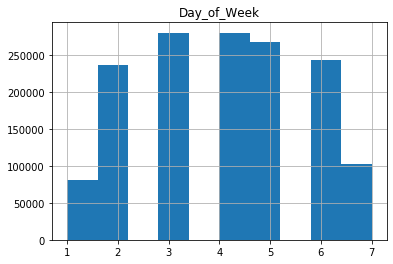

In [62]:
df1.hist()

khách hàng complaint nhiều nhất vào thứ 3,4

17. cho biết 20 sp nhận complaints nhiều nhất, vẽ biểu đồ

In [63]:
df_products = data_sub.groupby('product').count().orderBy('count', ascending=False).toPandas()

In [64]:
df_products.head()

,product,count
0,"Credit reporting, credit repair services, or o...",331635
1,Mortgage,295097
2,Debt collection,278961
3,Credit reporting,139825
4,Credit card,89175


In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

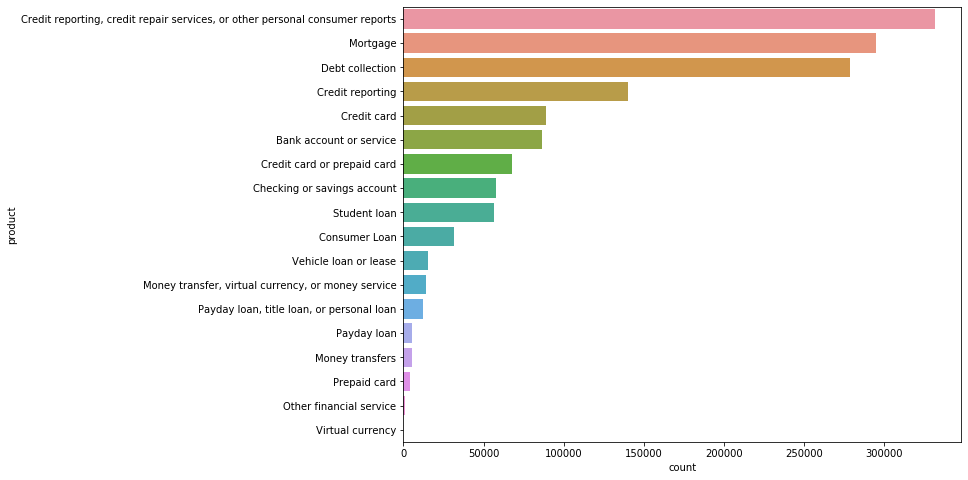

In [66]:
plt.figure(figsize=(10,8))
sns.barplot(data = df_products, x='count', y='product')
plt.show()